In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

In [12]:
if torch.cuda.is_available():
  dev = "cuda:0"
elif torch.backends.mps.is_available():
  dev = "mps"
else:  
  dev = "cpu"
print(dev)
device = torch.device(dev)

mps


In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
        self.mask_names = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
        self.transform = transform

        # Debug print statements
        print(f"Found {len(self.image_names)} images in {image_dir}")
        print(f"Found {len(self.mask_names)} masks in {mask_dir}")
        
        if len(self.image_names) == 0:
            raise ValueError(f"No images found in {image_dir}. Please check the directory path and file extensions.")
        if len(self.mask_names) == 0:
            raise ValueError(f"No masks found in {mask_dir}. Please check the directory path and file extensions.")
        if len(self.image_names) != len(self.mask_names):
            print(f"Number of images: {len(self.image_names)}")
            print(f"Number of masks: {len(self.mask_names)}")  
            raise ValueError("Number of images and masks do not match.")



    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(img_name).convert('L')  # Convert to grayscale
         # Debug print statement
        print(f"Accessing index: {idx}")

        mask_name = os.path.join(self.mask_dir, self.mask_names[idx])
        mask = Image.open(mask_name).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Transform for normalizing and resizing
transform = transforms.Compose([
    transforms.Resize((696, 520)),  # Resize images to 696x520
    transforms.ToTensor(),  # Convert PIL image to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Paths to your image and mask folders
image_dir = 'Data/train/01'
mask_dir = 'Data/train/01_MASKS'

# Datasets and DataloadersD
train_dataset = CustomImageDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Paths to your image and mask folders for validation(using test)
val_image_dir = 'Data/test/02'
val_mask_dir = 'Data/test/02_MASKS'

# Datasets and Dataloaders for test
val_dataset = CustomImageDataset(image_dir=val_image_dir, mask_dir=val_mask_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Debug print to verify DataLoader
for images, masks in val_loader:
    print(images.shape, masks.shape)
    break  # Just to test the first batch

Found 84 images in Data/train/01
Found 84 masks in Data/train/01_MASKS
Found 84 images in Data/test/02
Found 84 masks in Data/test/02_MASKS
Accessing index: 0
Accessing index: 1
Accessing index: 2
Accessing index: 3
Accessing index: 4
Accessing index: 5
Accessing index: 6
Accessing index: 7
torch.Size([8, 1, 696, 520]) torch.Size([8, 1, 696, 520])


In [10]:
# Double convolution block with padding
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        
        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, image):
        # Encoder
        print('ENTERED ENCODER')
        x1 = self.down_conv_1(image)
        print('ENTERED MAXPOOL')
        x2 = self.max_pool_2x2(x1)
        print('ENTERED CONV2')
        x3 = self.down_conv_2(x2)
        print('ENTERED MAXPOOL2')
        x4 = self.max_pool_2x2(x3)
        print('ENTERED CONV3')
        x5 = self.down_conv_3(x4)
        print('ENTERED MAXPOOL3')
        x6 = self.max_pool_2x2(x5)
        print('ENTERED CONV4')
        x7 = self.down_conv_4(x6)
        print('ENTERED MAXPOOL4')
        x8 = self.max_pool_2x2(x7)
        print('ENTERED CONV5')
        x9 = self.down_conv_5(x8)

        # Decoder
        print('ENTERED DECODER')

        #Before each concatenation in the decoder, we check if the sizes of the tensors match. If they don't, we use nn.functional.pad to pad the smaller tensor to match the dimensions of the larger tensor.This ensures that the tensors have the same dimensions before concatenation without cropping.
        x = self.up_trans_1(x9)
        if x.size() != x7.size():
            diffY = x7.size()[2] - x.size()[2]
            diffX = x7.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = self.up_conv_1(torch.cat([x, x7], 1))

        x = self.up_trans_2(x)
        if x.size() != x5.size():
            diffY = x5.size()[2] - x.size()[2]
            diffX = x5.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = self.up_conv_2(torch.cat([x, x5], 1))

        x = self.up_trans_3(x)
        if x.size() != x3.size():
            diffY = x3.size()[2] - x.size()[2]
            diffX = x3.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = self.up_conv_3(torch.cat([x, x3], 1))

        x = self.up_trans_4(x)
        if x.size() != x1.size():
            diffY = x1.size()[2] - x.size()[2]
            diffX = x1.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = self.up_conv_4(torch.cat([x, x1], 1))

        x = self.out(x)
        print('ENDED DECODER')

        return x

In [6]:
model = UNet()
# Check the model with one batch of data
# Should be [batch_size, 2, 696, 520]
for images, masks in train_loader:
    # images = images.to(device)
    outputs = model(images)
    print(f"Input shape: {images.shape}, Output shape: {outputs.shape}")
    break  # Just to test the first batch

Accessing index: 54
Accessing index: 59
Accessing index: 80
Accessing index: 39
Accessing index: 15
Accessing index: 55
Accessing index: 17
Accessing index: 14


KeyboardInterrupt: 

In [45]:
#image = torch.rand(1, 1, 696, 520)  # Batch size, channel, height, width
#model = UNet()
#output = model(image)
#print(output.size())  # Should be [1, 2, 696, 520]

showing the images in my batch

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# Function to denormalize the image
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Undo normalization
    return tensor

# Visualize a batch of images and masks
def visualize_batch(dataloader):
    for images, masks in dataloader:
        # Denormalize images
        images = denormalize(images)
        
        # Convert to numpy arrays
        images = images.numpy()
        masks = masks.numpy()
        
        # Plot the images and masks
        batch_size = images.shape[0]
        plt.figure(figsize=(12, 6))
        
        for i in range(batch_size):
            # Plot image
            plt.subplot(2, batch_size, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title("Image")
            plt.axis('off')

            # Plot mask
            plt.subplot(2, batch_size, i + 1 + batch_size)
            plt.imshow(masks[i].squeeze(), cmap='gray')
            plt.title("Mask")
            plt.axis('off')

        plt.show()
        break  # Just visualize the first batch


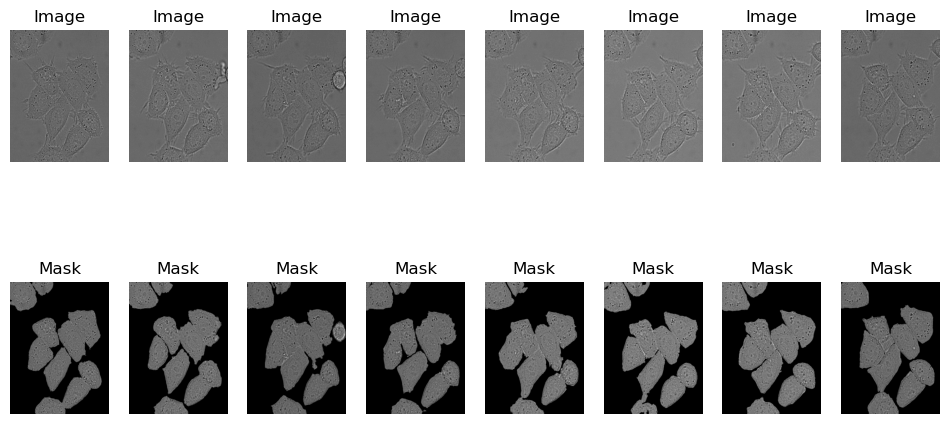

In [8]:
# Call the visualize function
visualize_batch(val_loader)

## initializing the model

In [13]:
model = UNet()

In [8]:
# checking dimentions
sample_image, sample_mask = next(iter(train_loader))  # Get a sample batch from the DataLoader
sample_output = model(sample_image)  # Perform a forward pass
print("Model Output Shape:", sample_output.shape)
print("Target Mask Shape:", sample_mask.shape)

# Check DataLoader and Dataset
print("Sample Image Shape:", sample_image.shape)
print("Sample Mask Shape:", sample_mask.shape)

Model Output Shape: torch.Size([8, 1, 696, 520])
Target Mask Shape: torch.Size([8, 1, 696, 520])
Sample Image Shape: torch.Size([8, 1, 696, 520])
Sample Mask Shape: torch.Size([8, 1, 696, 520])


## the training and validation loop

In [14]:
import torch.optim as optim
# Dice Loss Function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-6

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                    (iflat.sum() + tflat.sum() + smooth))

# Instantiate the model, define the loss function and the optimizer
criterion = DiceLoss()  # DiceLoss for semantic segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training and validation loop
num_epochs = 2
for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0

    for i,(images, masks) in enumerate(train_loader):
        print(f"Working on batch {i+1}")
        # Move tensors to the configured device (e.g., GPU if available)
        # images = images.to(device)
        # masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        print(f"Generated output for batch {i+1}")
        #print("Output shape:", outputs.shape)
        #print("Mask shape:", masks.shape)
        loss = criterion(outputs, masks)  
        print(f"Loss function for batch {i+1} = {loss.item()}")
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        print("Loss function backwarded")
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            # images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            # masks = masks.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Accessing index: 73
Accessing index: 70
Accessing index: 67
Accessing index: 33
Accessing index: 58
Accessing index: 24
Accessing index: 31
Accessing index: 5
Working on batch 1
ENTERED ENCODER
ENTERED MAXPOOL
ENTERED CONV2
ENTERED MAXPOOL2
ENTERED CONV3
ENTERED MAXPOOL3
ENTERED CONV4
ENTERED MAXPOOL4
ENTERED CONV5
ENTERED DECODER
ENDED DECODER
Generated output for batch 1
Loss function for batch 1 = 1.117592215538025
Loss function backwarded
Accessing index: 37
Accessing index: 64
Accessing index: 45
Accessing index: 8
Accessing index: 26
Accessing index: 49
Accessing index: 75
Accessing index: 78
Working on batch 2
ENTERED ENCODER
ENTERED MAXPOOL
ENTERED CONV2
ENTERED MAXPOOL2
ENTERED CONV3
ENTERED MAXPOOL3
ENTERED CONV4
ENTERED MAXPOOL4
ENTERED CONV5
ENTERED DECODER
ENDED DECODER
Generated output for batch 2
Loss function for batch 2 = 1.1060017347335815


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Dice Loss Function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-6

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                    (iflat.sum() + tflat.sum() + smooth))

# Instantiate the model, define the loss function and the optimizer
criterion = DiceLoss()  # DiceLoss for semantic segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training and validation loop
num_epochs = 2
for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0

    # Train on only one batch
    for i, (images, masks) in enumerate(train_loader):
        # Move tensors to the configured device (e.g., GPU if available)
        # images = images.to(device)
        # masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        #print("Output shape:", outputs.shape)
        #print("Mask shape:", masks.shape)
        loss = criterion(outputs, masks)  

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        break  # Exit after the first batch

    train_loss /= len(images)  # Adjusted to batch size instead of dataset size
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        # Validate on only one batch
        for i, (images, masks) in enumerate(val_loader):
            # images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            # masks = masks.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            break  # Exit after the first batch

    val_loss /= len(images)  # Adjusted to batch size instead of dataset size
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plotting the training and validation losses
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot losses
plot_losses(train_losses, val_losses)


## ploting the val and training loss

In [ ]:
# Plotting training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()